# Auto ownership estimation

In [1]:
import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

import pyproj as proj
from shapely.geometry import MultiPoint
from shapely import geometry

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables



In [2]:
mm.initialize()

Loading model step 'auto_ownership'
Loading model step 'WLCM'


In [3]:
@orca.table(cache=True)
def nodessmall():
    df = pd.read_csv('/home/data/2018-07/nodessmall_vars.csv')
    return df

@orca.table(cache=True)
def nodeswalk():
    df = pd.read_csv('/home/data/2018-07/nodeswalk_vars.csv')
    return df

In [4]:
#initialization only
orca.run(['initialize_network_small','initialize_network_walk'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [3]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 189769 rows because they contain missing values
Computing hh_10000
Removed 189769 rows because they contain missing values
Computing poor_10000
Removed 53114 rows because they contain missing values
Computing renters_10000
Removed 102597 rows because they contain missing values
Computing avg_income_10000
Removed 189769 rows because they contain missing values
Computing jobs_10000
Computing avg_rent_10000
Computing pop_white_10000
Removed 107372 rows because they contain missing values
Computing pop_black_10000
Removed 10541 rows because they contain missing values
Computing pop_asian_10000


KeyboardInterrupt: 

In [ ]:
orca.run(['initialize_network_walk','network_aggregations_walk'])

In [25]:
cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
orca.add_column('households', 'cars_alt', cars_alt)

In [26]:
# income bins
income_bins = pd.cut(orca.get_table('households').to_frame().income,
      bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
      labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
for i in income_bin_dummies.columns:
    orca.add_column('households',i,income_bin_dummies[i])

# tenure type dummy
orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# single family as integer
orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# building type dummy
orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

In [5]:
parcels = orca.get_table('parcels').to_frame()

In [6]:
def test_parcels():
    try: 
        orca.get_table('parcels').to_frame()
        print('parcels intact')
    except:
        print('cannot get parcels df')

In [27]:
# transit station within 0.5 km:
from sklearn.neighbors import BallTree
from IPython.display import display
agencies = list(glob.iglob('/home/jayne/ual_model_workspace/fall-2018-models/notebooks-jayne/Py27/data/gtfsfeed_text/*/stops.txt'))

parcels['transit'] = 0

for gtfs_stops in agencies:
    
    stops_df = pd.read_csv(gtfs_stops)[['stop_id','stop_lat','stop_lon']].set_index('stop_id')
    stops_rad = np.deg2rad(stops_df[['stop_lat','stop_lon']])
    parcels_rad = np.deg2rad(parcels[['y','x']])
    tree = BallTree(stops_rad,metric = 'haversine')

    ind = tree.query_radius(parcels_rad,r = 0.5/6371,count_only = True)
    parcels['transit'] += ind
    
    print(gtfs_stops.split('/')[-2])



San Francisco Municipal Transportation Agency
WestCAT
Caltrain Shuttles
Marin Transit
SamTrans
Petaluma Transit
Caltrain Commuter Shuttle (call for pick-up)
Golden Gate Transit
Caltrain
Emery Go-Round
AC Transit
County Connection
VTA
SolTrans
Fairfield and Suisun Transit
Bay Area Rapid Transit
Sonoma County Transit


In [28]:
orca.add_column('parcels','has_transit',(parcels['transit']>0).astype(int))

In [29]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])

In [16]:
# use UrbanAccess transit accessibility
# parcels_trn = pd.read_csv('/home/jayne/ual_model_workspace/fall-2018-models/notebooks-jayne/Py27/parcels_w_trn_acc.csv')
# todo: match parcels_trn with parcels, and fill NAs with median value.
parcels1 = pd.merge_ordered(parcels.reset_index(),
    parcels_trn[['parcel_id','jobs_45','jobs_30','jobs_15']],how = 'left', left_on = 'primary_id', right_on = 'parcel_id'
).drop('parcel_id',axis = 1).set_index('primary_id')

parcels1



,development_type_id,land_value,acres,county_id,zone_id,proportion_undevelopable,tax_exempt_status,apn,parcel_id_local,geom_id,...,x,y,shape_area,block_id,node_id,node_id_small,node_id_walk,jobs_45,jobs_30,jobs_15
primary_id,,,,,,,,,,,,,,,,,,,,,
1,19,0.0,0.173418,1,988,0.0,1,000O030000201,,1376527774841,...,-122.295134,37.828792,7.018000e+02,060014017003000,1378905424,1378905424,919332658,1776.48080,1000.61115,457.916400
2,19,0.0,51.509218,1,988,0.0,1,000O030000202,,5024880633978,...,-122.297730,37.829315,2.084506e+05,060014017003000,52983587,52983587,2379543987,5081.75050,1200.59230,115.160730
3,19,0.0,286.592714,1,988,0.0,1,000O030000300,,3804827486356,...,-122.308491,37.830256,1.159801e+06,060014017003003,30363887,30363887,367288019,0.14400,0.00000,0.000000
4,19,0.0,6.660009,1,988,0.0,1,000O030500103,,12835762165310,...,-122.302187,37.825310,2.695212e+04,060014017003015,1378905422,1378905422,3353207182,51438.89500,14422.22300,454.924200
5,19,0.0,51.649569,1,988,0.0,1,000O030500203,,4169567557964,...,-122.294897,37.825270,2.090186e+05,060014017003018,2379543933,2379543933,2379543967,50903.43800,15007.34400,503.951000
6,19,0.0,1.415492,1,988,0.0,1,000O030500308,,4179367820959,...,-122.302278,37.823969,5.728297e+03,060014017003017,30364111,30364111,3469208523,1955.86250,1446.41820,568.940400
7,19,0.0,2.573757,1,988,0.0,1,000O030500309,,8265005328620,...,-122.297178,37.821330,1.041563e+04,060014017003027,53034683,53034683,4974995482,929.80426,523.09705,3.828733
8,19,0.0,15.973755,1,988,0.0,1,000O030500316,,8484874902161,...,-122.299135,37.824482,6.464355e+04,060014017003015,429455546,429455546,4923455589,3159.45480,1454.78220,376.403750
9,14,0.0,2.350002,1,988,0.0,1,000O030500500,,12753553862283,...,-122.291638,37.825181,9.510128e+03,060014017003026,52983612,52983612,53060640,5276.59400,1157.30650,152.052000


In [18]:
for i in ['jobs_45','jobs_30','jobs_15']:
    orca.add_column('parcels',i, parcels1[i].fillna(parcels1[i].median()))
    test_parcels()

parcels intact
parcels intact
parcels intact


In [19]:
@orca.table(cache=True)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels','nodessmall','nodeswalk'])
    return df

In [20]:
m2 = SmallMultinomialLogitStep()
m2.name = 'auto_ownership'

In [21]:
m2.model_expression = OrderedDict([
    ('intercept', [1,2,3]), 
    ('income_2',[0]),
    ('income_4',[0]),
    ('income_6',[1]),
    ('income_8',[1]),
    ('income_10',[2,3]),
    ('income_12',[2,3]),
    ('income_12p',[1,2,3]),
    ('persons',[1,2,3]),
    ('age_of_head',[1,2,3]),
    ('workers',[2,3]),
    ('children',[1,3]),
    ('single_family_int',[1,2,3]),
    ('tenure_1',[[1,2,3]]),
    ('has_transit',[[1,2,3]]),
    ('county_1',[[1,2,3]]),
    ('county_75', [[1,2,3]]),
    ('units_sf_10000',[1,2,3]),
    ('renters_10000',[1,2,3]),
    ('jobs_45',[1,2,3]),
    ('jobs_30',[1,2,3]),
    ('jobs_15',[1,2,3]),
     ])


In [22]:
m2.tables = ['hh_merged']
m2.choice_column = 'cars_alt'

In [23]:
chooser_ids = orca.get_table('households').to_frame().sample(15000,random_state = 2).index.values # sample 15000 based on household ID
m2.filters = ['household_id in [{0}]'.format(','.join(map(str, chooser_ids)))]

In [31]:
m2.fit()

KeyError: 'cars_alt'

In [ ]:
m2.tags = ['auto','auto ownership','jayne','test']
m2.register()

In [64]:
m2.run()

In [65]:
predicted_choices = m2.probabilities[
    m2.probabilities.groupby(['_obs_id'])['_probability'].transform('max') ==  m2.probabilities['_probability']
]['_alt_id'].reset_index(drop=True)

<IPython.core.display.Javascript object>


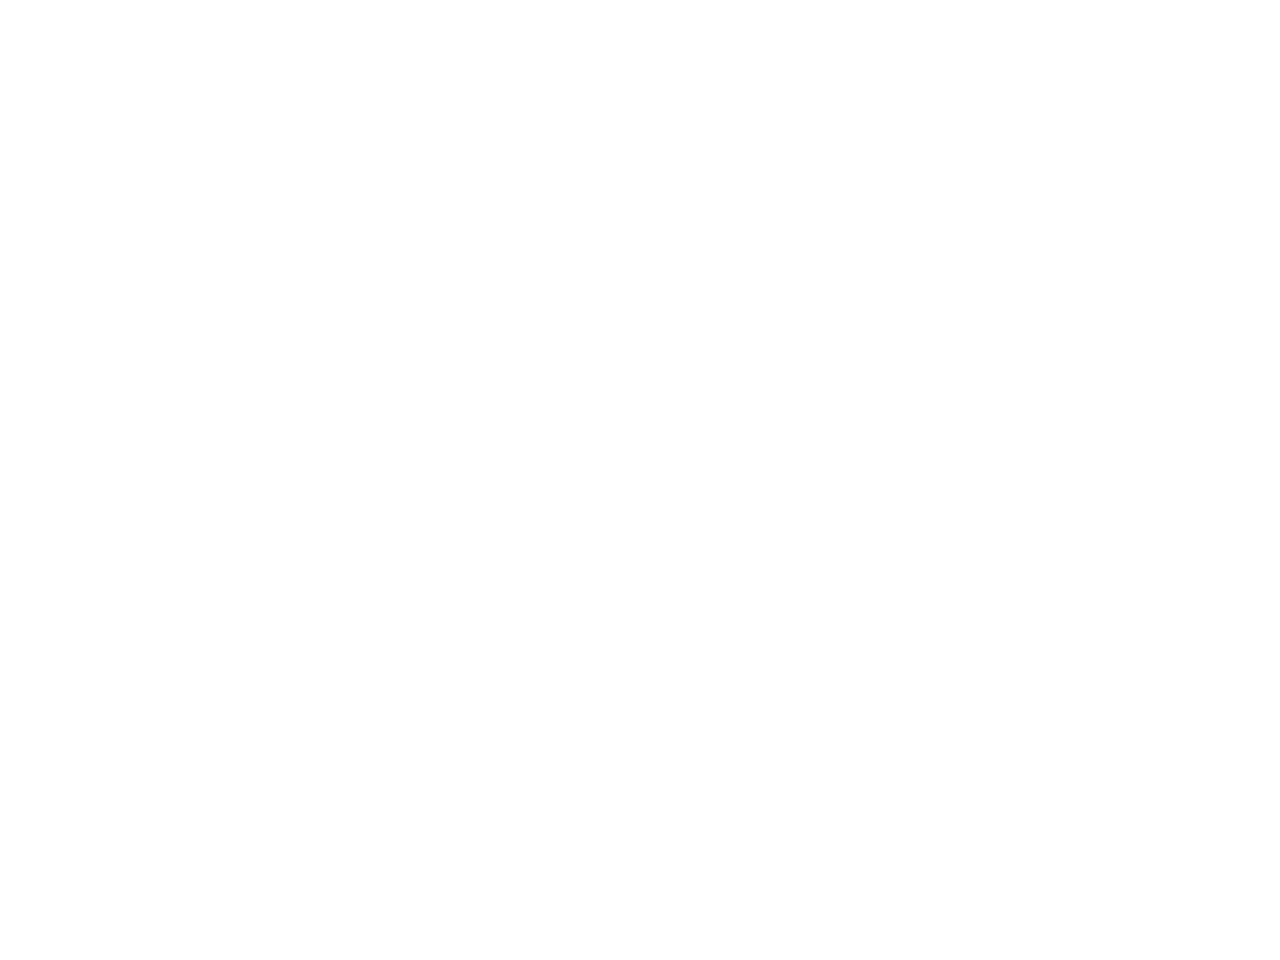

In [66]:
from sklearn.metrics import confusion_matrix
predicted_choices = m2.probabilities[
    m2.probabilities.groupby(['_obs_id'])['_probability'].transform('max') ==  m2.probabilities['_probability']
]['_alt_id']
ax = sns.heatmap(confusion_matrix(m2.choices,predicted_choices),annot=True, cmap="RdYlGn")
ax.set_xlabel('prediction')
ax.set_ylabel('true')
plt.show()

In [71]:
sum(m2.choices.reset_index(drop = True)==predicted_choices.reset_index(drop = True)) / len(predicted_choices)

0.5617339557559013

In [72]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf0 = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)
df = orca.get_table('hh_merged_1').to_frame().sample(15000,random_state = 2)

In [73]:
cols = [item for item in m2.model_expression]
X_mnl = df[list(set(cols) & set(df.columns))]
y = df['cars_alt']
cross_val_score(clf0, X_mnl, y, cv=4)

array([0.48933902, 0.4888    , 0.47932782, 0.50093358])

In [74]:
acc_cols = list(orca.get_table('nodessmall').to_frame().columns) + list(orca.get_table('nodeswalk').to_frame().columns)
X0 = df[acc_cols + ['income','persons','age_of_head','workers','children',
         'single_family_int','tenure_1','tenure_2','tenure_3','has_transit','county_1', 'county_13', 'county_41',
       'county_55', 'county_75', 'county_81', 'county_85', 'county_95',
       'county_97'
         
        ]]
y = df['cars_alt']

clf0.fit(X0,y)
importances = clf0.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(X0.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X0.shape[1]), X0.columns[indices],rotation = 90)
plt.xlim([-1, X0.shape[1]])
plt.show()

KeyError: "['osmid' 'units_10000' 'units_sf_10000' 'units_mf_10000' 'pop_10000'\n 'hh_10000' 'poor_10000' 'renters_10000' 'med_income_10000' 'jobs_10000'\n 'med_rent_10000' 'pop_white_10000' 'pop_black_10000' 'pop_asian_10000'\n 'pop_hisp_10000' 'units_25000' 'units_sf_25000' 'units_mf_25000'\n 'pop_25000' 'hh_25000' 'poor_25000' 'renters_25000' 'med_income_25000'\n 'jobs_25000' 'med_rent_25000' 'pop_white_25000' 'pop_black_25000'\n 'pop_asian_25000' 'pop_hisp_25000' 'osmid' 'units_500_walk'\n 'sqft_unit_500_walk' 'singles_500_walk' 'elderly_hh_500_walk'\n 'children_500_walk' 'units_sf_500_walk' 'units_mf_500_walk'\n 'pop_500_walk' 'hh_500_walk' 'poor_500_walk' 'rich_500_walk'\n 'renters_500_walk' 'avg_income_500_walk' 'jobs_500_walk'\n 'avg_rent_500_walk' 'pop_white_500_walk' 'pop_black_500_walk'\n 'pop_asian_500_walk' 'pop_hisp_500_walk' 'units_1500_walk'\n 'sqft_unit_1500_walk' 'singles_1500_walk' 'elderly_hh_1500_walk'\n 'children_1500_walk' 'units_sf_1500_walk' 'units_mf_1500_walk'\n 'pop_1500_walk' 'hh_1500_walk' 'poor_1500_walk' 'rich_1500_walk'\n 'renters_1500_walk' 'avg_income_1500_walk' 'jobs_1500_walk'\n 'avg_rent_1500_walk' 'pop_white_1500_walk' 'pop_black_1500_walk'\n 'pop_asian_1500_walk' 'pop_hisp_1500_walk' 'pop_2500_walk'\n 'pop_white_2500_walk' 'pop_black_2500_walk' 'pop_asian_2500_walk'\n 'pop_hisp_2500_walk' 'prop_children_500_walk' 'prop_singles_500_walk'\n 'prop_elderly_500_walk' 'prop_black_500_walk' 'prop_white_500_walk'\n 'prop_asian_500_walk' 'prop_hisp_500_walk' 'prop_rich_500_walk'\n 'prop_poor_500_walk' 'prop_children_1500_walk' 'prop_singles_1500_walk'\n 'prop_elderly_1500_walk' 'prop_black_1500_walk' 'prop_white_1500_walk'\n 'prop_asian_1500_walk' 'prop_hisp_1500_walk' 'prop_rich_1500_walk'\n 'prop_poor_1500_walk' 'pop_jobs_ratio_1500_walk' 'avg_hhs_500_walk'\n 'avg_hhs_1500_walk'] not in index"

In [75]:
X1 = X0[X0.columns[importances>0.01]]
cross_val_score(clf0, X1, y, cv=4)

NameError: name 'X0' is not defined

In [76]:
# feature used in X1
X1.columns

NameError: name 'X1' is not defined